In [1]:
import os , cv2 
import numpy as np

In [11]:
images_path = "./seg done/"

In [12]:
images = os.listdir(images_path)

In [13]:
os.makedirs("CarYolo" , exist_ok=True)

In [17]:
def preprocess_image(image):
    """
    used this to process and resize it and make is sutable for yolo annutations
    Args:
        image (path): the location of the images 
    Return:
        cv2 image
    """
    
    image = cv2.imread(image , cv2.IMREAD_COLOR)
    img = cv2.resize(image ,(640,640))
    return img

In [18]:
for image in images:
    image_path = images_path + image
    try:
        img = preprocess_image(image_path)
        cv2.imwrite(f"./CarYolo/{image}" , img)
    except :
        continue

In [2]:
import ultralytics
import matplotlib.pyplot as plt
import cv2
import uuid  # To generate unique IDs for each detection
model = ultralytics.YOLO('./best (1).pt')

In [3]:
str(uuid.uuid4()) + "_test"

'8df58558-70f4-4902-be02-0beef843dabf_test'

In [236]:
def pred_the_boxes(model , image_path , confidence_threshold = 0.4):
    img = cv2.imread(image_path)  
    results = model(img)
    result = results[0]
    predictions = []
    for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        if conf >= confidence_threshold:  
            x_min, y_min, x_max, y_max = box.tolist() 
            width = x_max - x_min
            height = y_max - y_min
            prediction = {
                "x": x_min + width / 2,  # Using the center x-coordinate
                "y": y_min + height / 2,  # Using the center y-coordinate
                "width": width,
                "height": height,
                "confidence": conf.item(),  # Convert tensor to float
                "class": result.names[int(cls)],  # Get class name
            }
            predictions.append(prediction)
    return predictions

In [251]:
def get_the_vis(image_path , predictions):
    image = cv2.imread(image_path)

    plt.title('image')
    plt.imshow(cv2.cvtColor(image , cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(10, 10))
    # Loop through each prediction
    for i, prediction in enumerate(predictions):
        # Extract x, y, width, and height from the prediction
        x_center = prediction["x"]
        y_center = prediction["y"]
        box_width = prediction["width"]
        box_height = prediction["height"]
        
        # Calculate top-left corner coordinates
        x_min = int(x_center - box_width / 2)
        y_min = int(y_center - box_height / 2)

        # Calculate bottom-right corner coordinates
        x_max = int(x_center + box_width / 2)
        y_max = int(y_center + box_height / 2)

        # Crop the region from the image
        cropped_image = image[y_min:y_max, x_min:x_max]
        # Save the cropped image with the class name
        class_name = prediction["class"]
        new_path = f"{uuid.uuid4()}_{i}.jpg"
        cv2.imwrite(f'{new_path}', cropped_image)
        # Plot each cropped image
        plt.subplot(3, 2, i + 1)  # Adjust the grid (2 rows, 2 columns for 4 images)
        plt.imshow(cv2.cvtColor(cropped_image , cv2.COLOR_RGB2BGR))
        plt.title(class_name)
        plt.axis('off')  # Turn off axes for better visualization
        print(f"Cropped and saved: {new_path}")

    # Display all the cropped images in the same figure
    plt.tight_layout()
    plt.show()

    print("Cropping and saving completed!")
    return new_path


In [252]:
image_path = './car plate.jpg'

0: 448x640 1 Plate, 586.2ms
Speed: 7.0ms preprocess, 586.2ms inference, 44.4ms postprocess per image at shape (1, 3, 448, 640)
Cropped and saved: 9367b4b3-ef09-4ed4-a748-66844699ff92_0.jpg


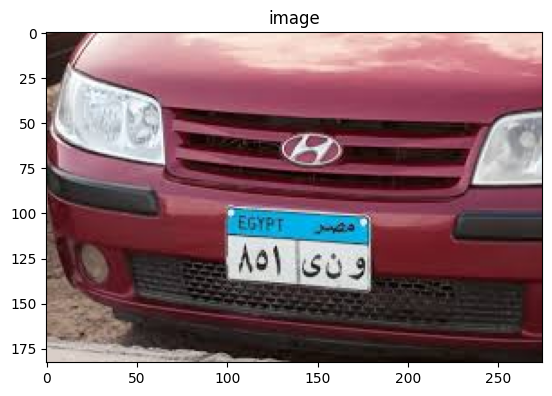

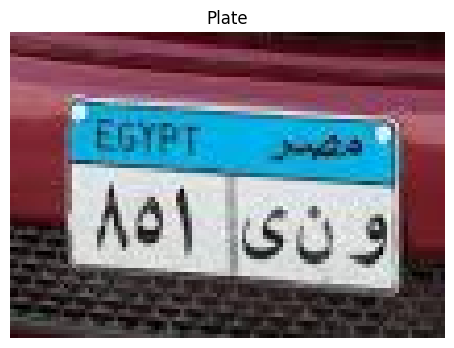

Cropping and saving completed!


In [253]:
predictions = pred_the_boxes(model , image_path)
new_image_path = get_the_vis(image_path, predictions)

In [254]:
from PIL import Image , ImageFilter , ImageEnhance
import easyocr
reader = easyocr.Reader(['en', 'ar'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [255]:
allowed_list = ['٠','١','٢','٣','٤','٥','٦','٧','٨','٩']
allowed_list_chars = [
    'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ',
    'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق',
    'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ٱ'
]

decoder = 'greedy'
beem_width ,contrast_ths = 50 , 0.3

In [256]:
def process_img(image , enhancer_val = 0.7):
        gray_image = image.convert('L')
        # Increase contrast
        enhancer = ImageEnhance.Contrast(gray_image)
        enhanced_image = enhancer.enhance(enhancer_val)  # Increase contrast
        # Sharpen image
        sharpened_image = enhanced_image.filter(ImageFilter.SHARPEN)
        image = sharpened_image
        return image

In [257]:
def get_numbers(image , allowed_list , decoder , beem_width , contrast_ths):
    text = reader.recognize(np.array(image) , allowlist=allowed_list,
                                    decoder=decoder , 
                                    beamWidth=beem_width,
                                    contrast_ths=contrast_ths)[0][1]
    if len(text) < 3 :
        return "the image is not good to get data"
    else:
        text = text
    return text

In [258]:
def get_chars(image , allowed_list , decoder , beem_width , contrast_ths):
    text = reader.recognize(np.array(image) , allowlist=allowed_list,
                                    decoder=decoder , 
                                    beamWidth=beem_width,
                                    contrast_ths=contrast_ths)[0][1]
    if len(text) < 3 :
        return "the image is not good to get data"
    else:
        return text

In [259]:
image = Image.open(new_image_path)

In [260]:
image = process_img(image)

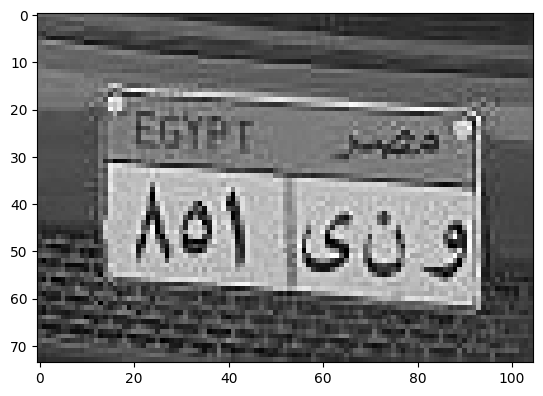

In [261]:
plt.imshow(cv2.cvtColor(np.array(image) , cv2.COLOR_RGB2BGR))

In [262]:
text_num =  get_numbers(image , allowed_list , decoder , beem_width , contrast_ths)

In [263]:
text_chars =  get_chars(image , allowed_list_chars , decoder , beem_width , contrast_ths)

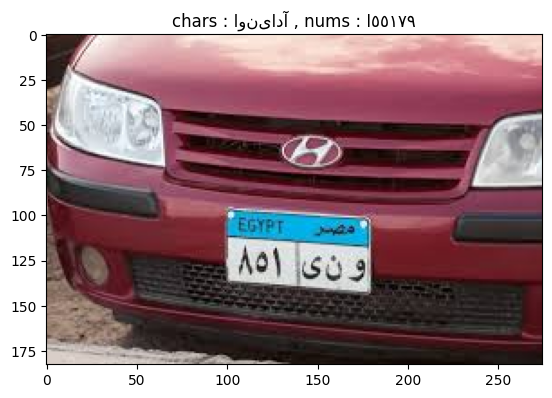

In [264]:
# plt.axis("off")
plt.title(
    f"chars : {text_chars} , nums : {text_num}"
)
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image , cv2.COLOR_RGB2BGR))


0: 640x640 1 Plate, 432.8ms
Speed: 7.0ms preprocess, 432.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Cropped and saved: 7f038e20-ae17-429d-9d80-e302a8e8efc6_0.jpg


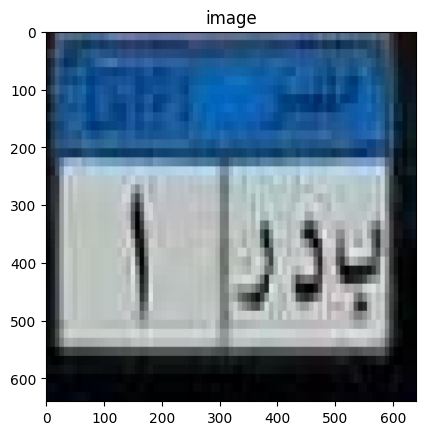

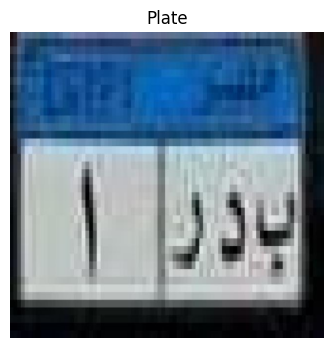

Cropping and saving completed!


In [265]:
image_path = './CarYolo/00055_jpg.rf.bef7497c10d5652fdb229a19c2a653ed.jpg'
predictions = pred_the_boxes(model , image_path)
new_image_path = get_the_vis(image_path, predictions)
image = Image.open(new_image_path)
image = process_img(image)
text_chars =  get_chars(image , allowed_list_chars , decoder , beem_width , contrast_ths)
text_num =  get_numbers(image , allowed_list , decoder , beem_width , contrast_ths)

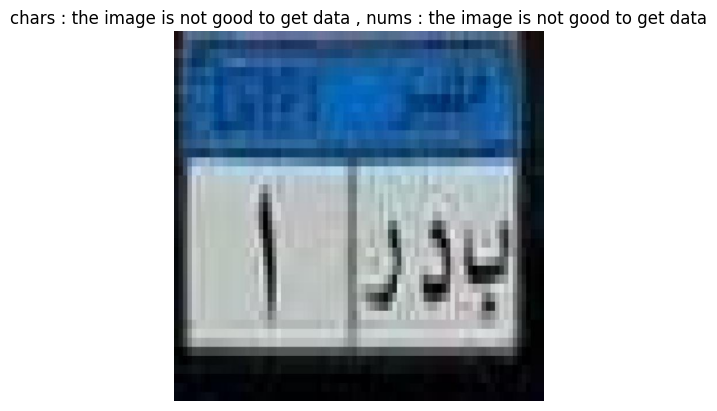

In [266]:
plt.axis("off")
plt.title(
    f"chars : {text_chars} , nums : {text_num}"
)
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image , cv2.COLOR_RGB2BGR))


0: 480x640 1 Plate, 230.1ms
Speed: 5.6ms preprocess, 230.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Cropped and saved: 2a8626ba-63f7-4f12-a74b-dcfac50cb576_0.jpg


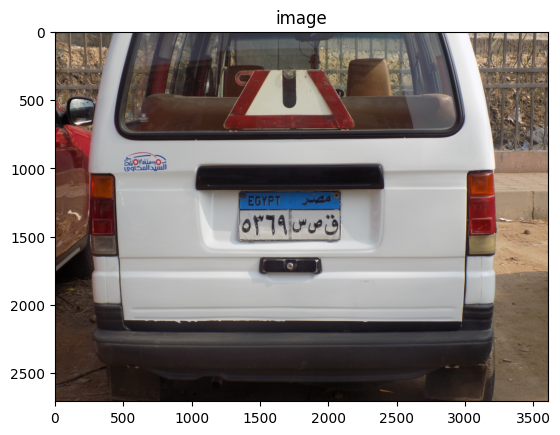

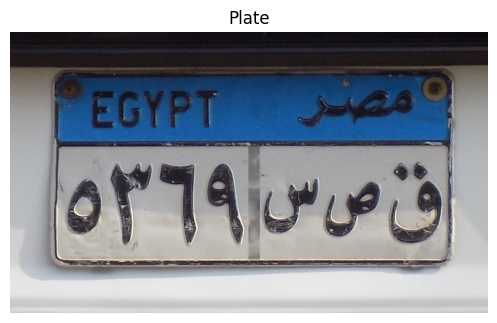

Cropping and saving completed!


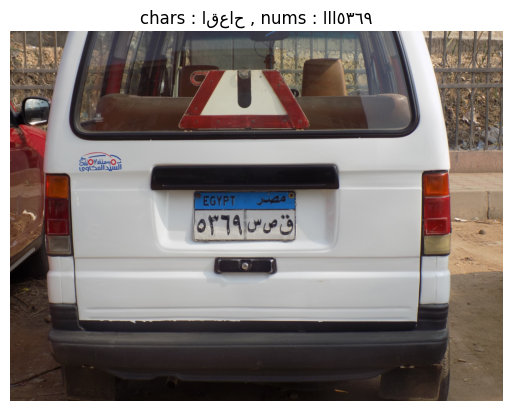

In [267]:
image_path = './seg done/DSCN7983.jpg'
predictions = pred_the_boxes(model , image_path)
new_image_path = get_the_vis(image_path, predictions)
image = Image.open(new_image_path)
image = process_img(image)
text_chars =  get_chars(image , allowed_list_chars , decoder , beem_width , contrast_ths)
text_num =  get_numbers(image , allowed_list , decoder , beem_width , contrast_ths)
plt.axis("off")
plt.title(
    f"chars : {text_chars} , nums : {text_num}"
)
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image , cv2.COLOR_RGB2BGR))

In [268]:
image_1 = './cat.jpg'
image_2 = './dog.jpg'

In [269]:
def resize_images(image:str , shape:tuple): 
    """
    resize the image shape to be same like the orignal image 
    Args:
        image (str): path of the image or np.ndarray image
        shape (tuple, optional): _description_. Defaults to (512,512).
    Return:
        image with the shape 512 , 512
    """
    try:
        try:
            image = cv2.imread(image)
        except:
            image = image
        image = cv2.resize(image , shape)
        return image
    except:
        print("please provide image or path to the image to process")
    

In [270]:
def blur_image(image) :
    return cv2.GaussianBlur(
        image , (7,7) , 11
    )

In [271]:
image_1 = resize_images(image_1 , (512,512))
image_2 = blur_image(resize_images(image_2 , (512,512)))

In [272]:
bland_image = cv2.addWeighted(src1=image_1 , alpha=0.5 , src2=image_2 , beta=0.5 , gamma=0.5)

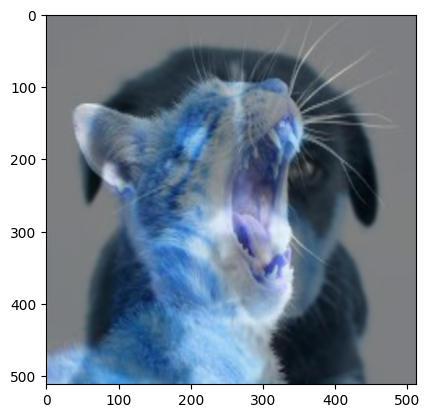

In [273]:
plt.imshow(bland_image)